Подгружаем модули

In [186]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import eli5

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)
import seaborn as sns
import xgboost as xgb
import catboost as ctb

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)
import seaborn as sns

import warnings

Импортируем библиотеки

In [187]:
df_sales_train = pd.read_hdf("../input/sales_train.h5")
df_sales_test = pd.read_hdf("../input/sales_test.h5")

df_sales_train.sample(5)

id  weekly_sales  store  dept        date  is_holiday
403400  403400  21538.410156     40     7  18/06/2010       False
210897  210897   6395.540039     11    30  31/12/2010        True
123115  123115    853.890015     29    28  07/10/2011       False
390140  390140   3170.709961     11     6  11/11/2011       False
183384  183384    509.010010      3    56  23/09/2011       False

In [188]:
print(df_sales_train.shape, df_sales_test.shape)
df_sales_train.info()

(285089, 6) (136481, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 285089 entries, 1 to 421567
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            285089 non-null  int32  
 1   weekly_sales  285089 non-null  float32
 2   store         285089 non-null  int8   
 3   dept          285089 non-null  int8   
 4   date          285089 non-null  object 
 5   is_holiday    285089 non-null  bool   
dtypes: bool(1), float32(1), int32(1), int8(2), object(1)
memory usage: 7.3+ MB


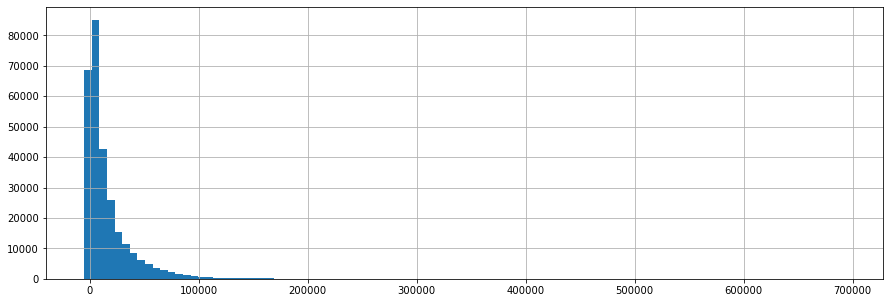

In [189]:
df_sales_train["weekly_sales"].hist(bins=100);

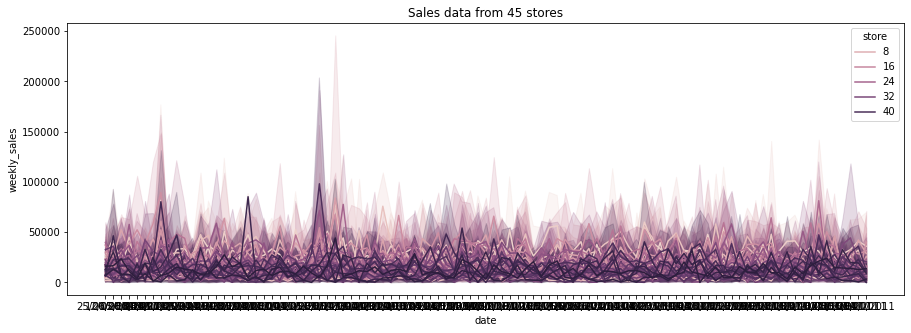

In [190]:
plt.title("Sales data from 45 stores")
sns.lineplot(x='date', y='weekly_sales', hue='store', data=df_sales_train.sample(frac=0.1));

##### Немного предыстории о моём опыте: 
анализ временного ряда (модель SARIMA, стационарность ряда и др.), в 
рамках DWthon прогнозрование банкротства банков (бинарная классификация), а также (мой первый опыт участия в DWthon)
прогнозирование цен на автомобили.
    

In [191]:
df_features_train = pd.read_hdf("../input/features_train.h5")
df_features_test = pd.read_hdf("../input/features_test.h5")

df_features_train["date"] = pd.to_datetime(df_features_train["date"])
df_features_test["date"] = pd.to_datetime(df_features_test["date"])

print(df_features_train.shape, df_features_test.shape)

(4365, 12) (3825, 3)


In [192]:
df_features_train.sample(5)

store       date  temperature  fuel_price  mark_down1  mark_down2  \
923       6 2010-07-05    23.156250    2.835938         NaN         NaN   
3001     17 2011-10-21     8.484375    3.578125         NaN         NaN   
750       5 2010-09-07    27.296875    2.642578         NaN         NaN   
7466     42 2010-05-03    13.289062    2.876953         NaN         NaN   
2095     12 2011-11-18    12.335938    3.812500      5956.0      343.25   

      mark_down3  mark_down4  mark_down5       cpi  unemployment  is_holiday  
923          NaN         NaN         NaN  211.8750      7.093750       False  
3001         NaN         NaN         NaN  129.7500      6.617188       False  
750          NaN         NaN         NaN  211.6250      6.496094       False  
7466         NaN         NaN         NaN  126.5625      9.765625       False  
2095     84.9375      2390.0     12936.0  129.8750     12.890625       False

Данные mark_down доступны только после ноября 2011 года и не всегда доступны для всех магазинов. Любые отсутствующие значения помечаются как NA. Будет ли это информативно для прогнозирования?

In [193]:
df_features_test.sample(5)

store       date  is_holiday
7061     39 2012-11-16       False
5240     29 2012-09-11       False
5561     31 2012-01-13       False
6144     34 2012-09-28       False
5377     30 2011-12-30        True

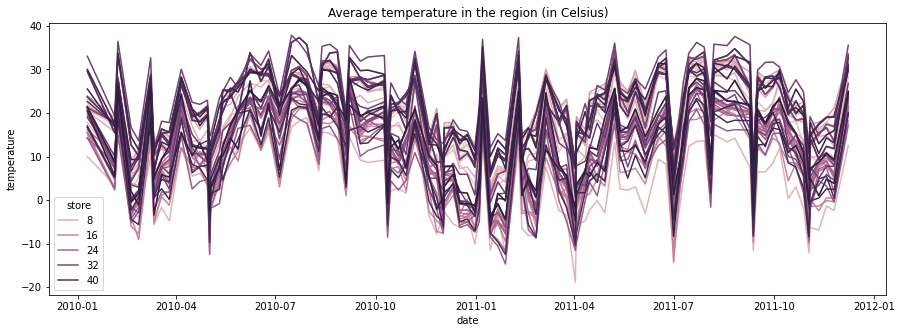

In [194]:
plt.title("Average temperature in the region (in Celsius)")
sns.lineplot(x='date', y='temperature', hue='store', data=df_features_train);

Стационарные ряды, цикличны (что в принципе логично)

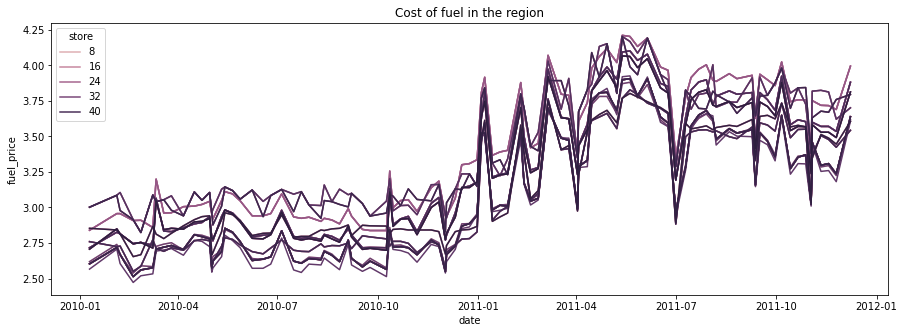

In [195]:
plt.title("Cost of fuel in the region")
sns.lineplot(x='date', y='fuel_price', hue='store', data=df_features_train);

Тренд из-за роста цен в 2011 году

In [196]:
df_store = pd.read_csv("../input/stores_data.csv")
print(df_store.shape)

df_store.columns = ["store", "type", "size"]

df_store.head(5)

(45, 3)


store type    size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

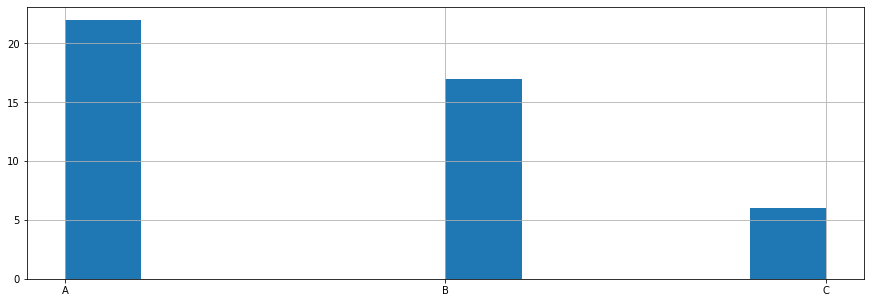

In [197]:
df_store["type"].hist();

Определённые магазины имеют определённый тип, и это неизменяемо во времени, необходим ли такой признак для предсказания?

In [198]:
feats = ["store", "dept"]

X_train = df_sales_train[ feats ].values
X_test = df_sales_test[ feats ].values

y_train = df_sales_train["weekly_sales"].values

In [199]:
model = DecisionTreeRegressor(max_depth=10)
scores = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error")

np.mean(scores), np.std(scores)

(-6120.117845672966, 52.99363392059167)

In [200]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [201]:
eli5.show_weights(model, feature_names=feats)

В стартере пробовали добавить признак "месяц", попробую добавить признак "выходной/не выходной"

In [202]:
def feature_engineering(df):
    df["is_holiday_int"] = df["is_holiday"].astype(int)
    return df


df_sales_train = feature_engineering(df_sales_train)
df_sales_test = feature_engineering(df_sales_test)

In [203]:
feats = ["store", "dept", "is_holiday_int"]

X_train = df_sales_train[ feats ].values
X_test = df_sales_test[ feats ].values

y_train = df_sales_train["weekly_sales"].values

In [204]:
model = DecisionTreeRegressor(max_depth=10)
scores = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error")

np.mean(scores), np.std(scores)

(-6134.023910722695, 42.92216899397907)

In [205]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [206]:
eli5.show_weights(model, feature_names=feats)

Данный признак не вносит существенный вклад, результат не улучшился. Неужели больше никакой признак не поможет улучшить качество?

In [207]:
df_sales_train["date"] = pd.to_datetime(df_sales_train["date"])
df_sales_test["date"] = pd.to_datetime(df_sales_test["date"])

df_sales_train.sample(5)

id  weekly_sales  store  dept       date  is_holiday  \
166579  166579   3349.100098     36     8 2011-09-16       False   
159538  159538   5193.660156     27    21 2011-05-20       False   
248607  248607  22268.509766     28    80 2011-04-02       False   
239256  239256   7838.069824     31    25 2010-09-17       False   
223730  223730   7261.950195     25    81 2011-06-05       False   

        is_holiday_int  
166579               0  
159538               0  
248607               0  
239256               0  
223730               0

In [208]:
df_sales_train["week"] = df_sales_train["date"].dt.week
df_sales_train["year"] = df_sales_train["date"].dt.year

In [209]:
df_sales_test["week"] = df_sales_test["date"].dt.week
df_sales_test["year"] = df_sales_test["date"].dt.year

In [210]:
df_sales_train["year_plus_1"] = df_sales_train["year"] + 1

In [211]:
feats = ["store", "dept", "is_holiday_int", "week", "year"]

X_train = df_sales_train[ feats ].values
X_test = df_sales_test[ feats ].values

y_train = df_sales_train["weekly_sales"].values

In [212]:
model = DecisionTreeRegressor(max_depth=10)
scores = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error")

np.mean(scores), np.std(scores)

(-6110.3500874773235, 53.69263934611328)

In [213]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [214]:
eli5.show_weights(model, feature_names=feats)

Чуть лучше результат, добавлю ещё фич по датам из стартера 4

In [215]:
def feature_engineering_new(df):
    df["dayofweek"] = df["date"].dt.dayofweek
    df["dayofyear"] = df["date"].dt.dayofyear
    
    return df

df_sales_train = feature_engineering_new(df_sales_train)
df_sales_test = feature_engineering_new(df_sales_test)

df_sales_train.sample(5)

id  weekly_sales  store  dept       date  is_holiday  \
103733  103733   4995.569824     25    22 2010-07-05       False   
232814  232814   2708.699951     42    67 2011-05-13       False   
34323    34323   5587.049805     32    42 2010-04-16       False   
249924  249924  47284.621094     17    92 2011-05-27       False   
6744      6744    200.960007     43    42 2011-08-26       False   

        is_holiday_int  week  year  year_plus_1  dayofweek  dayofyear  
103733               0    27  2010         2011          0        186  
232814               0    19  2011         2012          4        133  
34323                0    15  2010         2011          4        106  
249924               0    21  2011         2012          4        147  
6744                 0    34  2011         2012          4        238

Также добавлю данные по магазинам, как собственно в стартере 4

In [216]:
df_store = df_sales_train[ ["store", "dept", "weekly_sales"] ].groupby(["store", "dept"]).agg(["mean", "std", "median", "size"])["weekly_sales"].reset_index()
df_store.head()

store  dept          mean           std        median  size
0      1     1  22494.710938   9784.865234  18820.289062    97
1      1     2  45666.632812   3038.616211  45222.300781    97
2      1     3  12785.541992   8479.493164  10136.780273    97
3      1     4  36428.882812   2818.775635  36174.429688    97
4      1     5  24401.593750  12340.451172  21183.419922    97

In [217]:
df_sales_train_ext = pd.merge(df_sales_train, df_store, on=["store", "dept"], how="left").fillna(-1)
df_sales_test_ext = pd.merge(df_sales_test, df_store, on=["store", "dept"], how="left").fillna(-1)
df_sales_train_ext.head()

id  weekly_sales  store  dept       date  is_holiday  is_holiday_int  week  \
0   1  41272.601562     42    94 2010-09-07       False               0    36   
1   3   6212.770020     19    32 2011-08-19       False               0    33   
2   4  32530.310547     45     7 2011-10-06       False               0    40   
3   7   6199.310059     12    71 2011-05-20       False               0    20   
4   9   4262.890137     29    24 2010-10-09        True               1    40   

   year  year_plus_1  dayofweek  dayofyear          mean           std  \
0  2010         2011          1        250  34954.531250   3600.595947   
1  2011         2012          4        231   7794.950195   4158.146484   
2  2011         2012          3        279  24444.597656  21043.888672   
3  2011         2012          4        140   7402.809570   1781.085571   
4  2010         2011          5        282   4570.558594   1736.986206   

         median  size  
0  34704.488281    97  
1   7002.959961    97  
2  17425.750000    97  
3   7088.459961    97  
4   4262.890137    97

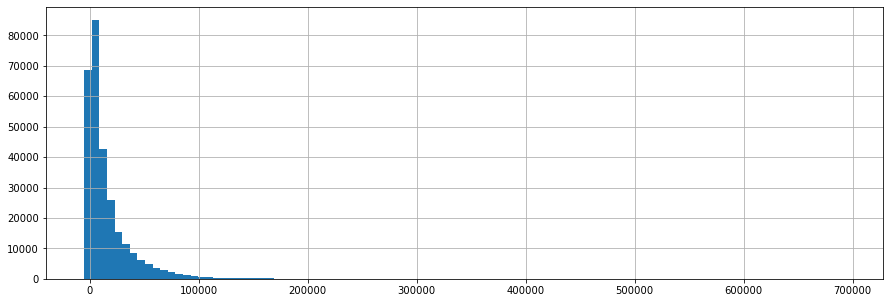

In [220]:
df_sales_train["weekly_sales"].hist(bins=100);

In [244]:
feats = ["store", "dept", "is_holiday", "week", "mean", "std", "median", "size"]

X_train = df_sales_train_ext[ feats ].values
X_test = df_sales_test_ext[ feats ].values

y_train = df_sales_train_ext["weekly_sales"].values
X_train = X_train[ y_train > 0 ]
y_train = y_train[ y_train > 0 ]


y_train_log = np.log(y_train)

In [227]:
model = xgb.XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.3, random_state=0)
model.fit(X_train, y_train_log)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [229]:
scores = cross_val_score(model, X_train, y_train_log, cv=3, scoring="neg_mean_absolute_error")
np.mean(scores), np.std(scores)

(-0.2506887912750244, 0.0005589891907137378)

In [230]:
eli5.show_weights(model, feature_names=feats)

In [233]:
model = xgb.XGBRegressor(max_depth=10, n_estimators=50, learning_rate=0.3, random_state=0)
model.fit(X_train, y_train_log)
scores = cross_val_score(model, X_train, y_train_log, cv=3, scoring="neg_mean_absolute_error")
np.mean(scores), np.std(scores)

(-0.2514465053876241, 0.0009716982612380653)

In [232]:
model = xgb.XGBRegressor(max_depth=10, n_estimators=150, learning_rate=0.3, random_state=0)
model.fit(X_train, y_train_log)
scores = cross_val_score(model, X_train, y_train_log, cv=3, scoring="neg_mean_absolute_error")
np.mean(scores), np.std(scores)

(-0.25200066963831586, 0.0006788163720377336)

В качестве результата была выбрала модель с параметрами n_estimators=50

In [245]:
model = xgb.XGBRegressor(max_depth=10, n_estimators=50, learning_rate=0.3, random_state=0)
model.fit(X_train, y_train_log)
scores = cross_val_score(model, X_train, y_train_log, cv=3, scoring="neg_mean_absolute_error")
np.mean(scores), np.std(scores)

(-0.2514465053876241, 0.0009716982612380653)

In [246]:
df_sales_test["weekly_sales"] = np.exp(model.predict(X_test))

df_sales_test[ ["id", "weekly_sales"] ].to_csv("../output/simple_xgb_log_em_1702.csv", index=False)